In [1]:
%matplotlib inline
import numpy as np
from scipy.optimize import curve_fit

import ipywidgets as widgets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from datetime import datetime

from joblib import Parallel, delayed, dump, load

Some useful matplotlib settings:

In [2]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

Some useful constants:

In [3]:
LAT = 53.24 # Latitude in Grunn
ABOVE_15 = False # Use the 'above 15 deg altitude' condition

date_signature = datetime.now().strftime('%d_%h_%Y')

Select the aperture: `telescope`, `guider`, or `finder`

In [4]:
aperture_name = widgets.Dropdown(
    options=['telescope', 'guider', 'finder'],
    value='telescope',
    description='Aperture:',
)

display(aperture_name)

Dropdown(description='Aperture:', options=('telescope', 'guider', 'finder'), value='telescope')

# Generating obstruction grids

Define a function to extract the file name of the joblib data files:

In [5]:
def file_name(n, ap_name='telescope'):
    fn = '../../scripts/data/' + str(aperture_name.value) + '/blocked_grid_az_' + str(n) + '.joblib'

    return fn

Combine the 2D data sets to create one 3D dataset of dimensions equal to the Az, HA, and Dec data.

In [6]:
# Empty array to store the new 3D data set in
obstr_cube = []

az_range = np.arange(0, 360, 1)

for n_az in az_range:
    with open(file_name(n_az), 'rb') as f:
        data = load(f)
        obstr_cube.append(data)

obstr_cube = np.array(obstr_cube)

with open('data/obstruction_cube_{}_{}.npy'.format(aperture_name.value, date_signature), 'wb') as f:
    np.save(f, obstr_cube)

Create a 3D grid of the HA, Dec, and Az. Calculate the altitude of the telescope & select all points above 15 degrees.

In [7]:
def altitude(ha, dec):
    """Returns altitude in deg."""
    lat = np.radians(LAT)
    dec = np.radians(dec)
    ha  = np.radians(ha)
    
    term_1 = np.sin(dec)*np.sin(lat)
    term_2 = np.cos(dec)*np.cos(lat)*np.cos(ha)
    
    a = np.degrees(np.arcsin(term_1 + term_2))
    
    return a

Then select the data points from the cube for with $a>15\ \text{deg}$ and the $\text{obstruction}\, \%$ is zero!

In [8]:
_az = np.linspace(0, 359, 360)
_ha = np.linspace(-179, 180, 360) 
_dec = np.linspace(-90, 90, 181)

az, ha, dec = np.meshgrid(_az, _ha, _dec, indexing='ij')

Define conditions for selecting the coordinates

In [9]:
alt = altitude(ha, dec)

obstr_cond = obstr_cube == obstr_cube.min()
alt_cond = alt >= 15

cond = obstr_cond

if ABOVE_15:
    cond &= alt_cond

Select the HA, Dec, and Az corresponding to no obstruction!

In [10]:
ha_zero = ha[cond]
ha_zero_shifted = np.where(ha_zero < 0, ha_zero + 360, ha_zero) # offset hour angle

dec_zero = dec[cond]
az_zero = az[cond]

Compute the range of HAs and Decs based on the min obstruction condition.

In [11]:
ha_range = np.arange(ha_zero.min(), ha_zero.max() + 1, 1)
ha_range_shifted = np.arange(ha_zero_shifted.min(), ha_zero_shifted.max() + 1, 1)
dec_range = np.arange(dec_zero.min(), dec_zero.max() + 1, 1)

## Plot

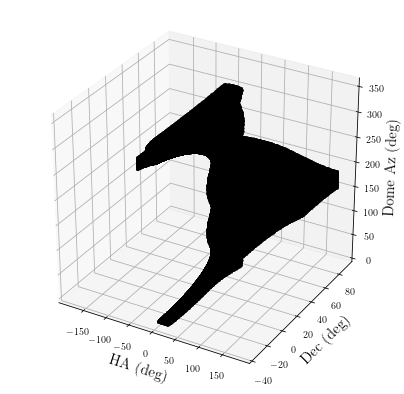

In [27]:
fig = plt.figure(figsize=(7, 7))
frame = fig.add_subplot(1, 1, 1, projection ='3d')

frame.grid(True, alpha=0.5)

frame.set_xlabel('HA (deg)', fontsize=15)
frame.set_ylabel('Dec (deg)', fontsize=15)
frame.set_zlabel('Dome Az (deg)', fontsize=15)

frame.plot(ha_zero[::], dec_zero[::], az_zero[::], color='black', ls='', alpha=0.5, marker='o', ms=2)

# frame.view_init(elev=30, azim=40)

plt.show()

## Optimal $A_d$

Define a function to extract the optimal azimuth from the $A_d$ grid. By selecting the point where (for a constant declination) the HA can move the longest westward, i.e. where the difference in HA is the largest.

In [33]:
a = np.array([1, 7, 2,4, 2])
a.sort()

In [42]:
a[0]

1

In [41]:
a[-1]

7

In [14]:
def delta_h(h, h_0):    
    return h - h_0  

# def delta_h(h, h_0, m=360):
#     k = (h % m) - (h_0 % m)
#     return k % m

# def ha_dist(ha_array, ha_0):
#     if ha_0 >= 0:
#         ha_array.sort()
    
#     try:
#         start = np.argwhere(np.isclose(ha_array, ha_0)).ravel()[0]
#     except IndexError:
#         return -1
    
#     diff = np.diff(ha_array)
#     diff_shifted = diff[start:]
    
#     if not diff_shifted.size:
#         return 0

#     if np.all(np.isclose(diff_shifted, 1)):
#         return diff_shifted.size

#     breaks = np.argwhere(~np.isclose(diff_shifted, 1)).ravel()
#     ha_dist = breaks[0]

#     if np.isclose(diff_shifted[ha_dist], -359):
#         if breaks.size > 1:
#             return diff_shifted[:breaks[1]].size
        
#         return diff_shifted.size

#     return ha_dist

def ha_dist(ha_array, ha_0):
    try:
        # Verify that the initial HA is indeed an option in ha_array
        start = np.argwhere(np.isclose(ha_array, ha_0)).ravel()[0]
    except IndexError:
        return -1

    ha_shifted = (ha_array - ha_0) % 360 # Set ha_0 to be 0
    ha_shifted.sort()
    
    idx = np.argwhere(~np.isclose(np.diff(ha_shifted), 1)).ravel()

    if idx.size > 0:
        return ha_shifted[:idx[0]].size
    
    return ha_shifted.size


Compute the optimal Az, for a certain function to calculate $\Delta h$...

In [20]:
np.intersect1d(

SyntaxError: unexpected EOF while parsing (<ipython-input-20-ba4ced8a8354>, line 1)

In [28]:
# def optimal_az(az_options, ha, dec):
#     dec_sel = np.argwhere(np.isclose(dec_zero, dec)).ravel()
    
#     azimuths = []
#     delta_hs = []
    
#     for az in az_options:
#         az_sel = np.argwhere(np.isclose(az_zero, az)).ravel()
        
#         indices = np.intersect1d(az_sel, dec_sel)
    
#         # Extract the range of possible HAs
#         hs = ha_zero_shifted[indices] # or use 'ha_zero_shifted'
        
#         print('possible dHAs:', np.diff(hs))
        
#         if hs.size:
#             dh = delta_h(hs, ha)
            
#             azimuths.append(az)
#             delta_hs.append(dh.max())
    
#     azimuths = np.array(azimuths)
#     delta_hs = np.array(delta_hs)
    
#     return azimuths[delta_hs.argmax()], delta_hs.max()

def optimal_az(az_options, ha, dec):
    dec_sel = np.argwhere(np.isclose(dec_zero, dec)).ravel()
    
    azimuths = []
    delta_hs = []
    
    for az in az_options:
        az_sel = np.argwhere(np.isclose(az_zero, az)).ravel()
        
        indices = np.intersect1d(az_sel, dec_sel)
        
        # Extract the range of possible HAs
        hs = ha_zero_shifted[indices]
        
        print('\n\n HAs for az = {} deg -> {}'.format(az, hs))
        
        if hs.size:
            dh = ha_dist(hs, ha)
            
            azimuths.append(az)
            delta_hs.append(dh)
            
            print('\n dHA =', dh, 'deg')
    
    azimuths = np.array(azimuths)
    delta_hs = np.array(delta_hs)
    
    return azimuths[delta_hs.argmax()], delta_hs.max()


## Selecting $A_d$ Values Given $(h,\delta)$ Pairs

In [1]:
# coords = []
# optimal_azimuths = []
# hour_angle_diff = []

# for h in ha_range_shifted:
#     print('ha =', h)
#     for d in dec_range:
#         # Select indices according to the given ha/dec
#         dec_sel = np.argwhere(np.isclose(dec_zero, d)).ravel()
#         ha_sel   = np.argwhere(np.isclose(ha_zero_shifted, h)).ravel()
#         #h_sel   = np.argwhere(np.isclose(h_selected, h)).ravel()

#         indices = np.intersect1d(ha_sel, dec_sel)

#         # Find the range of azimuth values
#         az = az_zero[indices]

#         # Display the results
#         if az.size > 0:
#             hd_cur = [h, d]
#             az_opt, dh = optimal_az(az, *hd_cur)
            
# #             print(dh)
            
#             coords.append(hd_cur)
#             optimal_azimuths.append(az_opt)
#             hour_angle_diff.append(dh)

# coords = np.array(coords)
# optimal_azimuths = np.array(optimal_azimuths)
# hour_angle_diff = np.array(hour_angle_diff)

In [ ]:
# coords = []
# optimal_azimuths = []
# hour_angle_diff = []

# def gen_opt_az(h):
#     for d in dec_range:
#         # Select indices according to the given ha/dec
#         dec_sel = np.argwhere(np.isclose(dec_zero, d)).ravel()
#         ha_sel   = np.argwhere(np.isclose(ha_zero_shifted, h)).ravel()
#         #ha_sel   = np.argwhere(np.isclose(h_selected, h)).ravel()

#         indices = np.intersect1d(ha_sel, dec_sel)

#         # Find the range of azimuth values
#         az = az_zero[indices]

#         # Display the results
#         if az.size > 0:
#             hd_cur = [h, d]
#             az_opt, dh = optimal_az(az, *hd_cur)
            
# #             print(dh)
            
#             coords.append(hd_cur)
#             optimal_azimuths.append(az_opt)
#             hour_angle_diff.append(dh)
    
#     print('finished ha = {:>3.0f} degrees at {}'.format(h, datetime.now().strftime('%H:%M')))

# results = Parallel(n_jobs=8, backend='multiprocessing')(delayed(gen_opt_az)(h) for h in ha_range_shifted)

## Store the Data

Zero obstruction:

In [ ]:
zero_obstruction_coords = np.column_stack([ha_zero, dec_zero, az_zero])
np.savetxt('data/zero_obstruction_{}_{}.csv'.format(aperture_name.value, date_signature), zero_obstruction_coords, delimiter=',')

Optimal azimuths:

In [ ]:
opt = np.column_stack([coords[:, 0], coords[:, 1], optimal_azimuths, hour_angle_diff/15])
np.savetxt('data/optimal_az_{}_{}.csv'.format(aperture_name.value, date_signature), opt, delimiter=',')

# Interactivelly Selecting $A_d$

In [29]:
@widgets.interact(ha=(ha_zero_shifted.min(), ha_zero_shifted.max(), 1.0), dec=(dec_zero.min(), dec_zero.max(), 1.0))
def update(ha=0.0, dec=0.0):
    # Select indices according to the given ha/dec
    dec_sel = np.argwhere(np.isclose(dec_zero, dec)).ravel()
    ha_sel   = np.argwhere(np.isclose(ha_zero_shifted, ha)).ravel()
    
    indices = np.intersect1d(ha_sel, dec_sel)
    
    # Find the range of azimuth values
    az = az_zero[indices]
    
    # Display the results
    if not az.size:
        print('No azimuths available!')
    else:
        print('Available az (deg): {:} az points\n'.format(az.size))
    
        for a in az:
            print('{:.0f}'.format(a), end=', ')
        
        hd_cur = [ha, dec]
        az_opt, dh = optimal_az(az, *hd_cur)
        
        print('\n\nThe optimal value is {:.0f} deg'.format(az_opt))
        print('\nThe max. HA dist. is {:.2f} h'.format(dh/15))

interactive(children=(FloatSlider(value=0.0, description='ha', max=359.0, step=1.0), FloatSlider(value=0.0, de…

In [43]:
test = np.array([181., 182., 183., 184., 185., 186., 187., 188., 189., 190., 191., 192., 193., 194.,
 195., 196., 197., 198., 199., 200., 201., 202., 203., 204., 205., 206., 207., 208.,
 209., 210., 211., 212., 213., 214., 215., 216., 354., 355., 356., 357., 358., 359.,
   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,  25.,  26., 176.,
 177., 178., 179., 180.])

In [44]:
h0 = 177

In [50]:
shifted = (test - h0) % 360
shifted.sort()
np.argwhere(~np.isclose(np.diff(shifted), 1)).ravel()[0]/15

In [54]:
shifted

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39., 177., 178., 179., 180.,
       181., 182., 183., 184., 185., 186., 187., 188., 189., 190., 191.,
       192., 193., 194., 195., 196., 197., 198., 199., 200., 201., 202.,
       203., 204., 205., 206., 207., 208., 209., 359.])

2.6